### ARIMA, ANN, CNN with SUNACTIVITY 

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [75]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [76]:
# Light version

# ------------------ 데이터 로드 --------------- #
# Dataset 불러오기 (train, test)
# 원하는 Batch 사이드 별로 불러오기 위해 Dataloader에 넣기
# ------------------ 모델 설계 ----------------- #
# nn 모델 정의 (init, forward)
# model.to(device)
# ------------------ 모델 학습, 최적화 ----------- #
# loss function
# optimizer
# train 함수 정의(dataloader, model, loss, optimizer)
	# batch size별로 train loop 돌기
		# compute prediction error
		# backpropagation
# test 셋에서도 학습 잘 되는지 확인하기(dataloader, model, loss)
	# batch size를 테스트셋 통으로 설정해서 돌리기
		# with torch.inference (optimize 하지 않고 확인: no gradient)
			# loss or metric 계산
# 학습 loop 돌기 (epoch 설정: epoch마다 모델은 파라미터를 학습하고 업데이트함)
	# 이때 train set, test set 각각 함수 사용해서 동시에 확인할 수 있음
# 원하는 모델을 torch.save
# 나중에 해당 모델을 load해서 prediction을 얻을 수 있음.

### SUNACTIVITY Data Load

In [77]:
import statsmodels.api as sm
print(sm.datasets.sunspots.NOTE)
data = sm.datasets.sunspots.load_pandas().data

data.index = pd.Index(sm.tsa.datetools.dates_from_range("1700", "2008"))
data.index.freq = data.index.inferred_freq
del data["YEAR"]
data.tail()

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



,SUNACTIVITY
2004-12-31,40.4
2005-12-31,29.8
2006-12-31,15.2
2007-12-31,7.5
2008-12-31,2.9


### 데이터 준비하기
- train & test
- Dataset, Dataloader for nn

In [78]:
test_length = 20
train = data[:-test_length] # 1700~1988    #### 여기를 꼭 Series로 넣어야 하나?
test = data[-test_length:] # 1989~2008

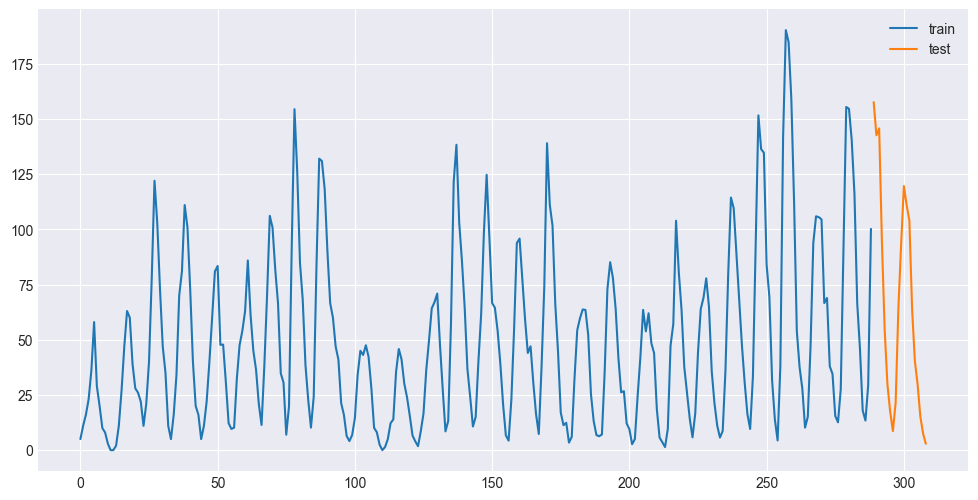

In [79]:
# Visualize train, test data
plt.figure(figsize=(12,6))
plt.plot(range(len(train)), train.SUNACTIVITY, label = "train")
plt.plot(range(len(train), len(train)+len(test)), test.SUNACTIVITY, label = "test")
plt.legend()
plt.show()
            

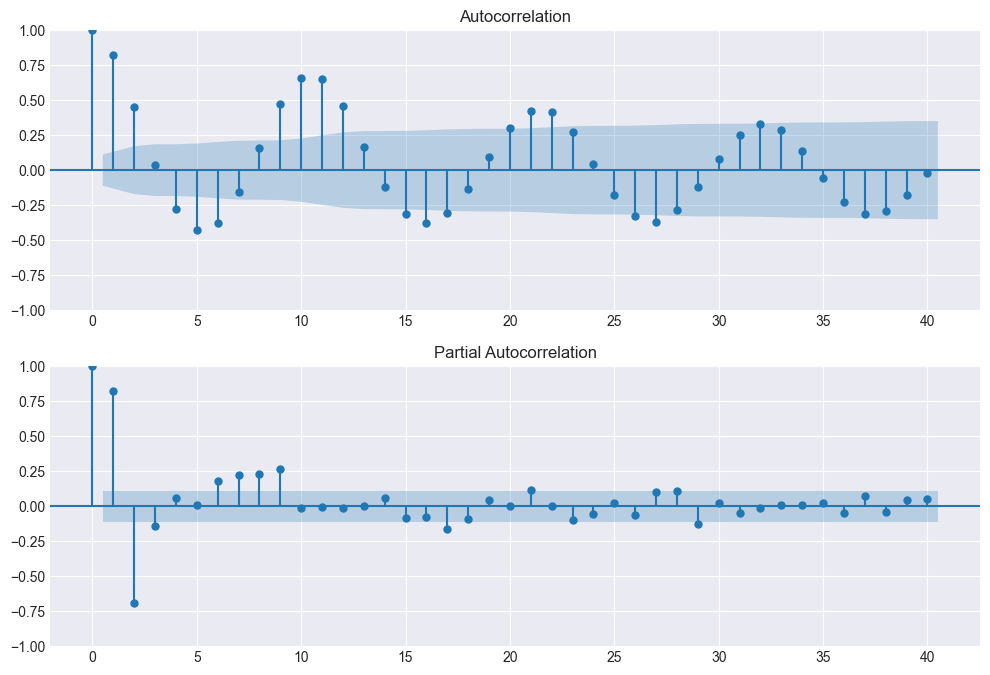

In [80]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12, 8)) 
ax1 = fig.add_subplot(211)
fig = plot_acf(data.values.squeeze(), lags=40, ax=ax1)  
# 시간이 갈 수록 ac의 영향이 줄어들고 있음. 
ax2 = fig.add_subplot(212)
fig = plot_pacf(data.values.squeeze(), lags=40, ax=ax2)  # shift된 값의 기여도
# 9년까지만 벗어나고, 그 이후에는 벗어나지 않음. -> AR사용해보자.

In [81]:
# Stationary Check
from statsmodels.tsa.stattools import adfuller

adf = adfuller(data)
print('ADF Statistic: {}'.format(adf[0]))
print('p-value: {}'.format(adf[1]))
print('Critical Values:')
for key, value in adf[4].items():
  print('\t{}: {}'.format(key, value))

ADF Statistic: -2.8377807249381966
p-value: 0.05307642172812041
Critical Values:
	1%: -3.4523371197407404
	5%: -2.871222860740741
	10%: -2.571929211111111


### Metrics
- MAPE
- MAE

In [82]:
def mape(y_pred, y_true): # mape = mean absolute percentage error
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

### ARIMA
- (9, 0, 0)

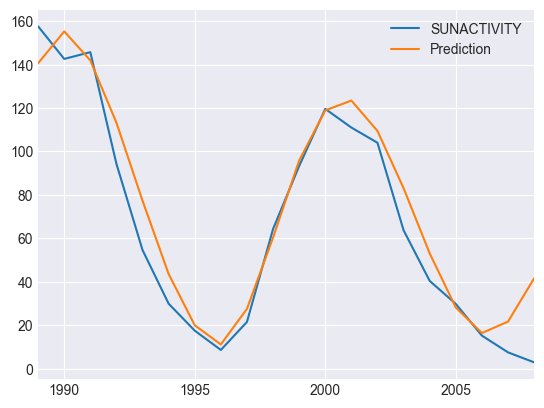

In [138]:
from statsmodels.tsa.arima.model import ARIMA

trn_ds, tst_ds = data.SUNACTIVITY[:-20], data.SUNACTIVITY[-20:]  # 20년치 자름 
arma_mod90 = ARIMA(trn_ds, order=(9,0,0)).fit() # p=9

prd = arma_mod90.predict("1989", "2008", dynamic=True)  # dynamic 여기선 업어도 되는데, 231215 task 2 -> 앞에 9개 보고, 1예측하고 다시 집어 넣고 
# 미래를 예측할 때에는 dynamic 무시됨
tst_ds.plot()
prd.plot(label="Prediction")
plt.legend()
plt.show()

In [137]:
prd

1989-12-31    140.606287
1990-12-31    155.268018
1991-12-31    141.919892
1992-12-31    113.238964
1993-12-31     77.306757
1994-12-31     43.576139
1995-12-31     19.954792
1996-12-31     11.139260
1997-12-31     27.523978
1998-12-31     60.343524
1999-12-31     95.795339
2000-12-31    118.898636
2001-12-31    123.428385
2002-12-31    109.421896
2003-12-31     83.060779
2004-12-31     53.078977
2005-12-31     28.134327
2006-12-31     16.397205
2007-12-31     21.645233
2008-12-31     41.578633
Freq: A-DEC, Name: predicted_mean, dtype: float64

In [85]:
tst_ds

1989-12-31    157.6
1990-12-31    142.6
1991-12-31    145.7
1992-12-31     94.3
1993-12-31     54.6
1994-12-31     29.9
1995-12-31     17.5
1996-12-31      8.6
1997-12-31     21.5
1998-12-31     64.3
1999-12-31     93.3
2000-12-31    119.6
2001-12-31    111.0
2002-12-31    104.0
2003-12-31     63.7
2004-12-31     40.4
2005-12-31     29.8
2006-12-31     15.2
2007-12-31      7.5
2008-12-31      2.9
Freq: A-DEC, Name: SUNACTIVITY, dtype: float64

In [145]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(trn_ds, order = (9,0,0), seasonal_order=(0,0,0,0))
pred = model.fit().forecast(len(tst_ds))

In [146]:
tst_ds

1989-12-31    157.6
1990-12-31    142.6
1991-12-31    145.7
1992-12-31     94.3
1993-12-31     54.6
1994-12-31     29.9
1995-12-31     17.5
1996-12-31      8.6
1997-12-31     21.5
1998-12-31     64.3
1999-12-31     93.3
2000-12-31    119.6
2001-12-31    111.0
2002-12-31    104.0
2003-12-31     63.7
2004-12-31     40.4
2005-12-31     29.8
2006-12-31     15.2
2007-12-31      7.5
2008-12-31      2.9
Freq: A-DEC, Name: SUNACTIVITY, dtype: float64

In [144]:
tst_ds.index

DatetimeIndex(['1989-12-31', '1990-12-31', '1991-12-31', '1992-12-31',
               '1993-12-31', '1994-12-31', '1995-12-31', '1996-12-31',
               '1997-12-31', '1998-12-31', '1999-12-31', '2000-12-31',
               '2001-12-31', '2002-12-31', '2003-12-31', '2004-12-31',
               '2005-12-31', '2006-12-31', '2007-12-31', '2008-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

<AxesSubplot: >

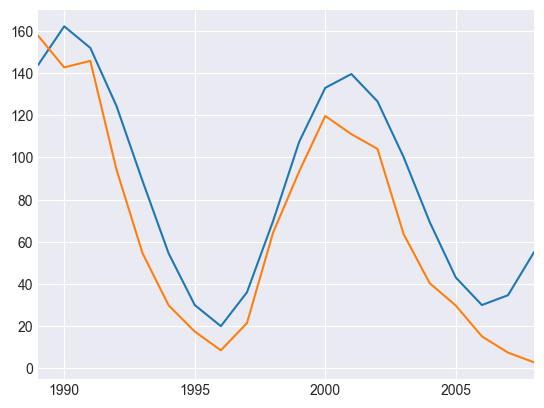

In [142]:
pred.plot()
tst_ds.plot(label="real")

In [87]:
pred

1989-12-31    143.752752
1990-12-31    162.051904
1991-12-31    151.837175
1992-12-31    124.383595
1993-12-31     88.801178
1994-12-31     54.502503
1995-12-31     30.043902
1996-12-31     20.033361
1997-12-31     36.057035
1998-12-31     69.784402
1999-12-31    107.327675
2000-12-31    132.919758
2001-12-31    139.463594
2002-12-31    126.516103
2003-12-31    100.150362
2004-12-31     69.376963
2005-12-31     43.077634
2006-12-31     30.045468
2007-12-31     34.692288
2008-12-31     55.146572
Freq: A-DEC, Name: predicted_mean, dtype: float64

In [88]:
mape(pred, tst_ds)

149.65653721144227

In [89]:
# ARIMA(9, 0, 0): (91.23301253371338, 10.625584397814194)
mape(prd,tst_ds), mae(prd,tst_ds)

(91.23301253371338, 10.625584397814194)

### Linear Regression with Neural Network

In [90]:
# Dataset, Dataloader

class TimeseriesDataset(torch.utils.data.Dataset):
    def __init__(self, data:pd.Series, window_size, prediction_size):
        self.data = data
        self.window_size = window_size
        self.prediction_size = prediction_size

    def __len__(self):
        return len(self.data) - self.window_size - self.prediction_size + 1
    
    def __getitem__(self, idx):
        x = self.data[idx:(idx+self.window_size)] # 예측을 위해 볼 과거 값들
        y = self.data[(idx+self.window_size):(idx+self.window_size+self.prediction_size)]  # 예측하려는 미래 값(들)
        return x, y

In [91]:
# without scaling

# window = 9
# prediction = 1
# test_length = 20

# # 인덱스 주의! 
# trn_ds = TimeseriesDataset(data["SUNACTIVITY"][:-test_length].to_numpy(dtype=np.float32), window, prediction)
# tst_ds = TimeseriesDataset(data["SUNACTIVITY"][-test_length-window:].to_numpy(dtype=np.float32), window, prediction) 
#     # 테스트 셋 첫번째 년도를 맞추기 위해선 그 전 9개 년도의 값이 필요함 -> 마지막 20년도를 테스트셋으로 쓰기 위해선 총 29개년도 값이 필요

In [92]:
# data["SUNACTIVITY"][:-test_length].to_numpy(dtype=np.float32)

In [93]:
from sklearn.preprocessing import MinMaxScaler

window = 9
prediction = 1
test_length = 20

# 인덱스 주의! 
scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(data[:-test_length].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(data[-test_length-window:].to_numpy(dtype=np.float32)).flatten()

trn_ds = TimeseriesDataset(trn_scaled, window, prediction)
tst_ds = TimeseriesDataset(tst_scaled, window, prediction) 
    # 테스트 셋 첫번째 년도를 맞추기 위해선 그 전 9개 년도의 값이 필요함 -> 마지막 20년도를 테스트셋으로 쓰기 위해선 총 29개년도 값이 필요

In [94]:
# trn_scaled.shape, tst_scaled.shape

In [95]:
# trn_scaled

In [96]:
trn_ds[279]

(array([0.8170347 , 0.81282866, 0.7381703 , 0.6093586 , 0.35015774,
        0.24132493, 0.09411146, 0.07045215, 0.15457414], dtype=float32),
 array([0.52681386], dtype=float32))

In [97]:
tst_ds[0]

(array([0.81282866, 0.7381703 , 0.6093586 , 0.35015774, 0.24132493,
        0.09411146, 0.07045215, 0.15457414, 0.52681386], dtype=float32),
 array([0.82860154], dtype=float32))

In [98]:
len(tst_ds)

20

In [99]:
# Dataloader: to load and iterate over the dataset in batches
## each batch: a tensor with shape (batch_size, input_size)
from torch.utils.data import Dataset, DataLoader
trn_dl = DataLoader(trn_ds, shuffle=True, batch_size = 32)
tst_dl = DataLoader(tst_ds, shuffle=False, batch_size = len(tst_ds))


In [100]:
inp, tgt = trn_ds[8]

In [101]:
inp

array([0.05257624, 0.04206099, 0.01577287, 0.        , 0.        ,
       0.01051525, 0.05783386, 0.14195584, 0.24710831], dtype=float32)

In [102]:
len(tst_ds)

20

In [103]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([32, 9]), torch.Size([32, 1]))

In [104]:
x  # trn_ds에는 280개의 데이터가 있음. one iteration: 이 중에서 9(window size)개씩 32번을 뽑음. 

tensor([[0.3360, 0.3628, 0.4090, 0.3412, 0.1877, 0.1115, 0.0584, 0.0300, 0.0457],
        [0.1052, 0.0841, 0.0263, 0.0578, 0.1157, 0.2103, 0.3155, 0.4253, 0.4385],
        [0.1377, 0.1404, 0.0636, 0.0499, 0.0142, 0.0263, 0.1283, 0.2208, 0.3339],
        [0.2266, 0.2497, 0.2219, 0.1477, 0.0531, 0.0426, 0.0131, 0.0000, 0.0074],
        [0.1788, 0.3680, 0.4259, 0.5836, 0.5310, 0.3838, 0.2103, 0.1052, 0.0841],
        [0.3344, 0.1977, 0.1372, 0.0747, 0.0305, 0.0878, 0.2329, 0.3360, 0.3628],
        [0.1446, 0.4863, 0.8170, 0.8128, 0.7382, 0.6094, 0.3502, 0.2413, 0.0941],
        [0.1872, 0.3838, 0.4474, 0.4101, 0.3365, 0.2198, 0.1377, 0.1404, 0.0636],
        [0.1746, 0.4869, 0.7971, 0.7166, 0.7082, 0.4411, 0.3649, 0.1656, 0.0731],
        [0.0641, 0.0731, 0.1861, 0.2408, 0.2161, 0.1583, 0.1257, 0.0820, 0.0347],
        [0.1199, 0.0536, 0.1267, 0.4359, 0.6940, 0.6882, 0.6209, 0.4727, 0.3502],
        [0.4458, 0.3580, 0.2024, 0.1199, 0.0536, 0.1267, 0.4359, 0.6940, 0.6882],
        [0.4863,

In [105]:
y # x에서 뽑은 9개년도의 바로 다음년도의 값 (우리가 맞춰야할 prediction)

tensor([[0.1898],
        [0.2508],
        [0.2829],
        [0.0263],
        [0.0263],
        [0.4090],
        [0.0705],
        [0.0499],
        [0.0231],
        [0.0210],
        [0.3155],
        [0.6209],
        [0.4359],
        [0.0226],
        [0.5463],
        [0.0505],
        [0.2834],
        [0.1420],
        [0.1446],
        [0.1335],
        [0.0747],
        [0.0594],
        [0.0789],
        [0.8360],
        [0.1840],
        [0.8118],
        [0.4101],
        [0.3260],
        [0.5547],
        [0.0000],
        [0.0941],
        [0.4411]])

In [106]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([32, 9]), torch.Size([32, 1]))

In [107]:
x, y = next(iter(tst_dl))
x.shape, y.shape

(torch.Size([20, 9]), torch.Size([20, 1]))

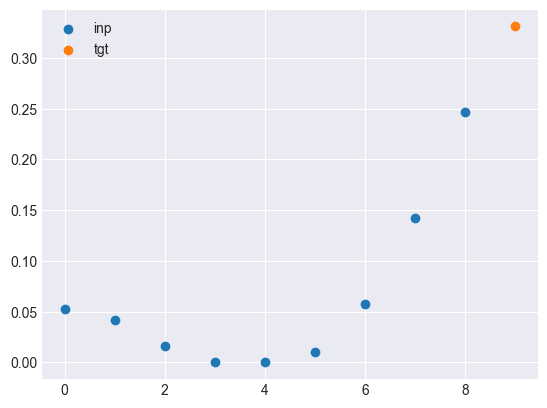

In [108]:
plt.scatter(range(len(inp)), inp, label='inp')   # window_size
plt.scatter(range(len(inp), len(inp) + len(tgt)), tgt, label='tgt')   # prediction_size
plt.legend()
plt.show()

In [109]:
# Model: ANN
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, activation = F.relu):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)
        self.activation = activation
    
    def forward(self, x):
        x = self.lin1(x)
        x = self.activation(x)
        x = self.lin2(x)
        return F.sigmoid(x)


In [110]:
# train function for one epoch
def train_one_epoch(dataloader, model, loss_func, optimizer, device):
    model.train()
    total_loss = 0. 
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_func(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss = loss.item()*len(y)
    trn_loss = total_loss/len(dataloader.dataset)
    return trn_loss

def test_one_epoch(dataloader, model, loss_func, metric, device):
    model.eval()
    total_loss, total_metric = 0., 0.
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        # print(x) 
        # print(y)
        with torch.inference_mode():
            pred = model(x)
            loss = loss_func(pred, y)
            metric_value = metric(pred, y)
            total_loss = loss.item()*len(y)
            total_metric = metric_value.item()*len(y)
    tst_loss = total_loss/len(dataloader.dataset)
    tst_metric = total_metric/len(dataloader.dataset)
    pred = pred.numpy()
    return tst_loss, tst_metric, pred   
        

In [111]:
## train & eval together
from tqdm.auto import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANN(input_dim=9, output_dim=1, hidden_dim = 128).to(device)  
optim = torch.optim.AdamW(model.parameters(), lr = 0.0001)
loss = F.mse_loss
metric = F.l1_loss

pbar = trange(1000)
for i in pbar: # loop
    trn_loss = train_one_epoch(trn_dl, model, loss, optim, device)
    tst_loss, tst_metric, pred = test_one_epoch(tst_dl, model, loss, metric, device)
    pbar.set_postfix({'trn_mse': trn_loss, 'tst_mse': tst_loss, 'tst_mae': tst_metric})
    # print(pred)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

In [112]:
tst_loss, tst_metric, pred = test_one_epoch(tst_dl, model, loss, metric, device)
x, y = next(iter(tst_dl))
y = scaler.inverse_transform(y)
p = scaler.inverse_transform(pred)
y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

In [113]:
y

array([157.6000073 , 142.60001111, 145.69999188,  94.30000387,
        54.59999906,  29.89999895,  17.49999934,   8.6000003 ,
        21.5000004 ,  64.30000582,  93.30000148, 119.59999578,
       110.99999903, 103.99999929,  63.69999985,  40.40000138,
        29.79999984,  15.20000007,   7.50000022,   2.9000001 ])

In [114]:
p

array([152.09805 , 163.66231 , 123.71687 , 110.32778 ,  66.980095,
        24.472782,  15.86818 ,  14.9239  ,  28.215025,  62.788696,
       119.319954, 129.17793 , 114.4194  ,  93.14176 ,  75.55501 ,
        41.541245,  20.62774 ,  19.74718 ,  20.725693,  25.92688 ],
      dtype=float32)

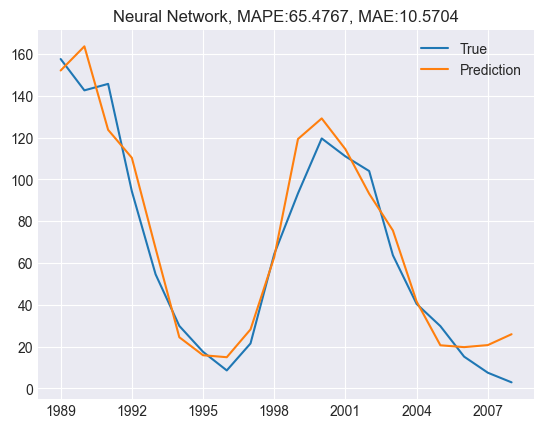

In [115]:
plt.title(f"Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}")
years = list(range(1989, 2009))
plt.plot(years[:test_length], y, label="True")
plt.plot(years[:test_length], p, label="Prediction")
plt.legend()
plt.xticks(years[:test_length:3])
plt.show()

# res_dict.update({'NN(9,512,4)': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})

### Multi-channel NN
- rolling mean을 추가해서 멀티 채널로 만들어보기

In [116]:
m_data = data.copy()
m_data["rolling_mean"] = data["SUNACTIVITY"].rolling(11).mean()
m_data = m_data.dropna()

In [117]:
m_data

,SUNACTIVITY,rolling_mean
1710-12-31,3.0,19.909091
1711-12-31,0.0,19.454545
1712-12-31,0.0,18.454545
1713-12-31,2.0,17.181818
1714-12-31,11.0,16.090909
...,...,...
2004-12-31,40.4,61.254545
2005-12-31,29.8,61.245455
2006-12-31,15.2,61.036364
2007-12-31,7.5,60.936364


<AxesSubplot: >

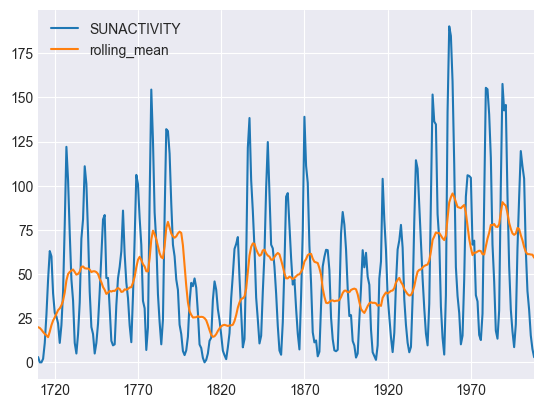

In [118]:
m_data.plot()

In [119]:
window = 9
prediction = 1
test_length = 20

# 인덱스 주의! 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(m_data[:-test_length].to_numpy(dtype=np.float32))
tst_scaled = scaler.transform(m_data[-test_length-window:].to_numpy(dtype=np.float32))

trn_ds = TimeseriesDataset(trn_scaled, window, prediction)
tst_ds = TimeseriesDataset(tst_scaled, window, prediction) 

# Dataloader: to load and iterate over the dataset in batches
## each batch: a tensor with shape (batch_size, input_size)
from torch.utils.data import Dataset, DataLoader
trn_dl = DataLoader(trn_ds, shuffle=True, batch_size = 32)
tst_dl = DataLoader(tst_ds, shuffle=False, batch_size = len(tst_ds))


In [120]:
trn_ds[0]

(array([[0.01577287, 0.06931245],
        [0.        , 0.06372276],
        [0.        , 0.05142538],
        [0.01051525, 0.03577417],
        [0.05783386, 0.02235888],
        [0.14195584, 0.01229738],
        [0.24710831, 0.        ],
        [0.33123028, 0.03801006],
        [0.31545743, 0.08272777]], dtype=float32),
 array([[0.20504732, 0.11514814]], dtype=float32))

In [121]:
x, y = next(iter(trn_dl)) # Batch, Length, Channel
x.shape, y.shape

(torch.Size([32, 9, 2]), torch.Size([32, 1, 2]))

In [122]:
x, y = next(iter(tst_dl)) # Batch, Length, Channel = batch_size, window, num_features
x.shape, y.shape

(torch.Size([20, 9, 2]), torch.Size([20, 1, 2]))

In [123]:
# x.flatten(start_dim, end_dim) 
# x.flatten(1)은 index 1 차원부터 피라는 뜻!
x.flatten(1).shape # window의 차원을 flatten 해서 3D 였던 걸 2D로 변환 

torch.Size([20, 18])

In [124]:
y[:,:,0] # rolling 말고 그냥 y값이랑 비교할 거니까

tensor([[0.8286],
        [0.7497],
        [0.7660],
        [0.4958],
        [0.2871],
        [0.1572],
        [0.0920],
        [0.0452],
        [0.1130],
        [0.3381],
        [0.4905],
        [0.6288],
        [0.5836],
        [0.5468],
        [0.3349],
        [0.2124],
        [0.1567],
        [0.0799],
        [0.0394],
        [0.0152]])

In [125]:
y[:,:,0].shape

torch.Size([20, 1])

In [126]:
class ANNMulti(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, input_channel, activation = F.relu):
        super().__init__()
        self.lin1 = nn.Linear(input_dim * input_channel, hidden_dim) # flatten 해서 들어가는 것처럼, 곱하기 해주어야 하는건가?
        self.lin2 = nn.Linear(hidden_dim, output_dim)
        self.activation = activation
    def forward(self, x):
        x = x.flatten(1) # (Batch, input_dim, input_channel) -> (Batch, input_dim * input_channel)
        x = self.lin1(x) # (Batch, hidden_dim)
        x = self.activation(x)
        x = self.lin2(x) # (Batch, output_dim)
        return F.sigmoid(x)

In [127]:
# train function for one epoch
def train_one_epoch(dataloader, model, loss_func, optimizer, device):
    model.train()
    total_loss = 0. 
    for x, y in dataloader:
        x, y = x.flatten(1).to(device), y[:,:,0].to(device) # 2D로 맞춰줌
        pred = model(x)
        loss = loss_func(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss = loss.item()*len(y)
    trn_loss = total_loss/len(dataloader.dataset)
    return trn_loss

def test_one_epoch(dataloader, model, loss_func, metric, device):
    model.eval()
    total_loss, total_metric = 0., 0.
    for x, y in dataloader:
        x, y = x.flatten(1).to(device), y[:,:,0].to(device) # 2D로 맞춰줌
        with torch.inference_mode():
            pred = model(x)
            loss = loss_func(pred, y)
            metric_value = metric(pred, y)
            total_loss = loss.item()*len(y)
            total_metric = metric_value.item()*len(y)
    tst_loss = total_loss/len(dataloader.dataset)
    tst_metric = total_metric/len(dataloader.dataset)
    pred = pred.numpy()
    return tst_loss, tst_metric, pred   
        

  0%|          | 0/1000 [00:00<?, ?it/s]

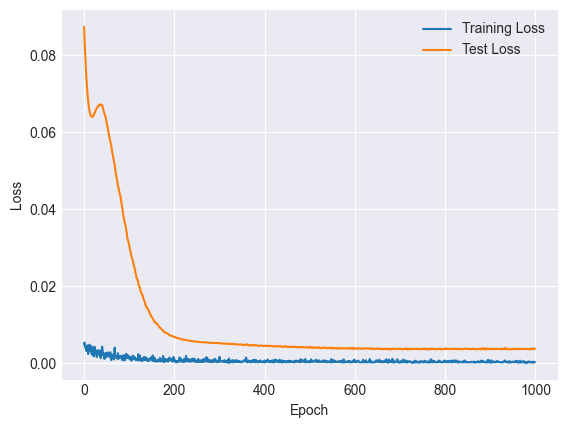

In [128]:
## train & eval together
from tqdm.auto import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ANNMulti(input_dim=9, output_dim=1, hidden_dim = 128, input_channel=2).to(device)  
optim = torch.optim.AdamW(model.parameters(), lr = 0.0001)
loss = F.mse_loss
metric = F.l1_loss

epochs = 1000
trn_loss_lst = []
tst_loss_lst = []
pbar = trange(epochs)
for i in pbar: # loop
    trn_loss = train_one_epoch(trn_dl, model, loss, optim, device)
    tst_loss, tst_metric, pred = test_one_epoch(tst_dl, model, loss, metric, device)
    trn_loss_lst.append(trn_loss)
    tst_loss_lst.append(tst_loss)
    pbar.set_postfix({'trn_mse': trn_loss, 'tst_mse': tst_loss, 'tst_mae': tst_metric})
    # print(pred)

# Plotting the losses
plt.plot(range(epochs), trn_loss_lst, label='Training Loss')
plt.plot(range(epochs), tst_loss_lst, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
    

In [129]:
model.eval()
with torch.inference_mode():
  x, y = next(iter(tst_dl))
  x, y = x.flatten(1).to(device), y[:,:,0].to(device)
  p = model(x)

y = y/scaler.scale_[0] + scaler.min_[0]
p = pred/scaler.scale_[0] + scaler.min_[0]
y = np.concatenate([y[:,0], y[-1,1:]])
p = np.concatenate([p[:,0], p[-1,1:]])

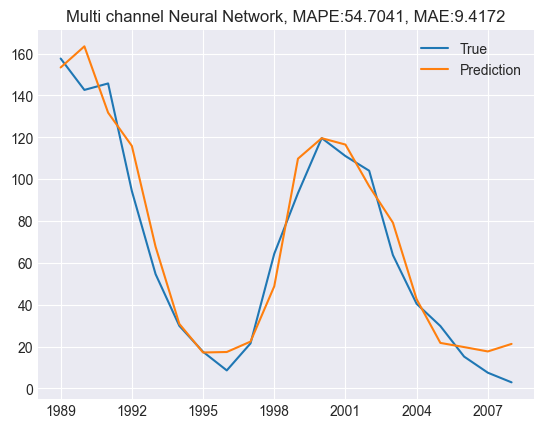

In [130]:
plt.title(f"Multi channel Neural Network, MAPE:{mape(p,y):.4f}, MAE:{mae(p,y):.4f}")
years = list(range(1989, 2009))
plt.plot(years[:test_length], y, label="True")
plt.plot(years[:test_length], p, label="Prediction")
plt.legend()
plt.xticks(years[:test_length:3])
plt.show()

# res_dict.update({'NN(9,512,4)': {'MAPE':mape(p,y), 'MAE':mae(p,y)}})

### Transformer (PatchTST)
patch_length = 16
n_patches = 8
prediction_length = 4
window_size = int(patch_length * n_patches / 2)

- patchTST:  시계열용으로 최근에 만들어진 모델
		- "A Time Series is Worth 64 Words: Long-term Forecasting with Transformers (2023)"
			- Yuqi Nie: [유튜브](https://www.youtube.com/watch?v=Z3-NrohddJw), [깃허브](https://github.com/yuqinie98/PatchTST/blob/main/PatchTST_self_supervised/src/models/layers/pos_encoding.py)
			- 고려대 설명: [유튜브](https://www.youtube.com/watch?v=VrqkXrwpohw)
		- 데이터셋 구성 방법
			- 시계열 중에서 16개씩 7개를 떼어옴
				- 0~16, 8~24, 16~32, 24~40, 32~48, 40~56, 48~64 (8씩 겹치게)
			- 24 ~ 맨 마지막은 다름 - 상수
			- 총 16 * 8 /2 = 64개가 일반적

In [131]:
class PatchTSDataset(torch.utils.data.Dataset):
    def __init__(self, ts: np.array, patch_length: int=16, n_patches: int=8, prediction_length: int=4):
        self.data = ts # time series data
        self.P = patch_length
        self.N = n_patches
        self.L = int(patch_length*n_patches/2) # 반절씩 겹치니까 /2, look-back window length
        self.T = prediction_length

    def __len__(self):
        return len(self.data) - self.L - self.T + 1
    
    def __getitem__(self, i): # i == 0
        look_back = self.data[i:(i+self.L)] # data[0:64]
        look_back = np.concatenate([look_back, # data[0:64]
                                    look_back[-1]*np.ones(int(self.P/2), dtype=np.float32)]) # data[]
                                    # 뒤에서부터 반절씩 겹치기 ?
        x = np.array([look_back[j*int(self.P/2):(j+2)*int(self.P/2)] for j in range(self.N)]) # look_back[0:16] for i in range(8)
        y = self.data[(i+self.L):(i+self.L+self.T)] # y=data[64:68]
        return x, y

In [132]:
patch_length = 16
n_patches = 8
prediction_length = 4
window_size = int(patch_length * n_patches / 2)
test_length = 20

scaler = MinMaxScaler()
trn_scaled = scaler.fit_transform(data[:-test_length].to_numpy(dtype=np.float32)).flatten()
tst_scaled = scaler.transform(data[-test_length-window_size:].to_numpy(dtype=np.float32)).flatten()

trn_ds = PatchTSDataset(trn_scaled, patch_length, n_patches)
tst_ds = PatchTSDataset(tst_scaled, patch_length, n_patches)

trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size=test_length, shuffle=False)

In [133]:
look_back = trn_scaled[0:64]
look_ones = look_back[-1]*np.ones(8, dtype=np.float32)  # 16개씩 뽑아와야 하니까 마지막 패치의 남은 갯수 맞추기
look_ones

array([0.23711883, 0.23711883, 0.23711883, 0.23711883, 0.23711883,
       0.23711883, 0.23711883, 0.23711883], dtype=float32)

In [134]:
trn_ds[0]

(array([[0.02628812, 0.05783386, 0.08412198, 0.12092534, 0.18927446,
         0.3049422 , 0.1524711 , 0.10515247, 0.05257624, 0.04206099,
         0.01577287, 0.        , 0.        , 0.01051525, 0.05783386,
         0.14195584],
        [0.05257624, 0.04206099, 0.01577287, 0.        , 0.        ,
         0.01051525, 0.05783386, 0.14195584, 0.24710831, 0.33123028,
         0.31545743, 0.20504732, 0.14721346, 0.13669822, 0.11566772,
         0.05783386],
        [0.24710831, 0.33123028, 0.31545743, 0.20504732, 0.14721346,
         0.13669822, 0.11566772, 0.05783386, 0.1104101 , 0.21030495,
         0.41009465, 0.6414301 , 0.54153526, 0.38380653, 0.24710831,
         0.18401682],
        [0.1104101 , 0.21030495, 0.41009465, 0.6414301 , 0.54153526,
         0.38380653, 0.24710831, 0.18401682, 0.05783386, 0.02628812,
         0.08412198, 0.1787592 , 0.36803365, 0.42586753, 0.5835962 ,
         0.53102   ],
        [0.05783386, 0.02628812, 0.08412198, 0.1787592 , 0.36803365,
         0.4258

In [135]:
x, y = next(iter(trn_dl))
x.shape, y.shape

(torch.Size([32, 8, 16]), torch.Size([32, 4]))